# Quantificação da evolução de canais fluviais com Landlab
Estes exercícios baseiam‑se em um projeto originalmente desenvolvido por Kelin Whipple na Arizona State University. Este notebook foi criado por Nicole Gasparini na Tulane University.

<hr>
<small>Para tutoriais sobre Landlab, clique aqui: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

**O que é este notebook?**

Este notebook ilustra a evolução de canais limitados por destacamento em uma paisagem sujeita a soerguimento ativo. A paisagem evolui de acordo com a equação:

$$\frac{d z}{d t} = -K_\text{sp} A^{m_{sp}} S^{n_{sp}} + U$$

Aqui, $K_{sp}$ é o coeficiente de erodibilidade para a incisão fluvial, geralmente correlacionado positivamente com a umidade/clima chuvoso e negativamente com a resistência da rocha. Os expoentes $m_{sp}$ e $n_{sp}$ são positivos e costumam obedecer à razão $m_{sp}/n_{sp} \approx 0{,}5$. $A$ é a área de drenagem e $S$ é a declividade do trecho de maior inclinação ($-\frac{dz}{dx}$), onde $x$ é a distância horizontal (positiva na direção do fluxo) e $z$ é a elevação. (Se a declividade for negativa, não ocorre erosão fluvial.) $U$ é o campo de soerguimento rochoso imposto externamente.

O termo de erosão fluvial também é conhecido como equação de potência de fluxo (*stream‑power*). Antes de utilizar este notebook, é importante estar familiarizado com essa equação por meio das aulas e leituras.

Para uma excelente visão geral da equação de potência de fluxo, consulte: 

- **Whipple e Tucker (1999)**, *Dynamics of the stream‑power river incision model: Implications for height limits of mountain ranges, landscape response timescales, and research needs*, *Journal of Geophysical Research*.

Para ótimos exemplos de modelagem com a equação, consulte: 

- **Tucker e Whipple (2002)**, *Topographic outcomes predicted by stream erosion models: Sensitivity analysis and intermodel comparison*, *Journal of Geophysical Research*.

Informações complementares sobre a sensibilidade da paisagem a taxas e padrões de soerguimento podem ser encontradas em:

- **Kirby e Whipple (2012)**, *Expression of active tectonics in erosional landscapes*, *Journal of Structural Geology*.


**Agora vamos ao código...**

Primeiro, precisamos importar as partes do Python e do Landlab necessárias para executar este notebook. Você não deve alterar este primeiro bloco de código.

In [1]:
# Code block 1

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from landlab import RasterModelGrid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
)

Crie uma grade e defina as condições de contorno.

In [2]:
# Code Block 2

number_of_rows = 50  # número de células na direção vertical (y)
number_of_columns = 100  # número de células na direção horizontal (x)
dxy = 200  # tamanho lateral de uma célular do modelo raster, ou resolução [m]

# Below is a raster (square cells) grid, with equal width and height
mg1 = RasterModelGrid((number_of_rows, number_of_columns), dxy)

# Set boundary conditions - only the south side of the grid is open.
# Boolean parameters are sent to function in order of
# east, north, west, south.
mg1.set_closed_boundaries_at_grid_edges(True, True, True, False)

Aqui criamos a grade inicial de elevação zerada com uma pequena quantidade de ruído para gerar uma rede de drenagem mais realista.

In [3]:
# Code Block 3

np.random.seed(35)  # seed set so our figures are reproducible

# intial noise on elevation grid
mg1_noise = np.random.rand(mg1.number_of_nodes) / 1000.0

# set up the elevation on the grid
z1 = mg1.add_zeros("topographic__elevation", at="node")
z1 += mg1_noise

Defina os parâmetros relacionados ao tempo.

In [4]:
# Code Block 4

tmax = 5e5  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 1000  # time step [yr] (Original value was 100 yr)

Defina os parâmetros de incisão e inicialize todos os componentes do modelo. Também inicializamos ferramentas para quantificar a paisagem.

In [5]:
# Code Block 5

# Original K_sp value is 1e-5
K_sp = 1.0e-5  # units vary depending on m_sp and n_sp
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

frr = FlowAccumulator(mg1, flow_director="FlowDirectorD8")  # intializing flow routing

# initializing stream power incision
spr = StreamPowerEroder(mg1, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0)

theta = m_sp / n_sp
# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg1, reference_concavity=theta, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf = ChiFinder(
    mg1, min_drainage_area=1000.0, reference_concavity=theta, use_true_dx=True
)

Inicialize a taxa de soerguimento de rocha. Ela poderá ser alterada mais tarde.

In [6]:
# Code Block 6

#  uplift_rate [m/yr] (Original value is 0.0001 m/yr)
uplift_rate = np.ones(mg1.number_of_nodes) * 0.0001

Agora vem o loop principal de execução.

Você pode executar o Bloco de Código 7 repetidamente; enquanto não redefinir o campo de elevação (Bloco 3), a paisagem continuará evoluindo. Se alterar parâmetros em outros blocos (por exemplo, 5 ou 6), basta executá‑los novamente para que os novos valores passem a valer sobre a topografia atual.

In [7]:
# Code Block 7

total_time = 0.0
with tqdm(total=tmax) as pbar:
    while total_time < tmax:
        z1[mg1.core_nodes] += uplift_rate[mg1.core_nodes] * dt  # uplift the landscape
        frr.run_one_step()  # route flow
        spr.run_one_step(dt)  # fluvial incision
        total_time += dt

        pbar.update(dt)

  0%|          | 0/500000.0 [00:00<?, ?it/s]

Plote a topografia.

Maximum elevation is 50.00007214607302


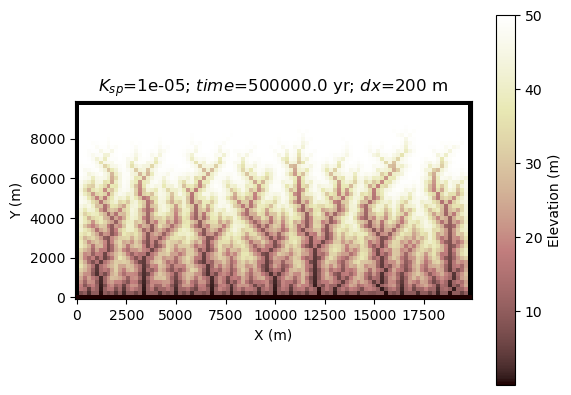

In [8]:
# Code Block 8

mg1.imshow("topographic__elevation", grid_units=("m", "m"), var_name="Elevation (m)")
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m"
plt.title(title_text)

max_elev = np.max(z1)
print(f"Maximum elevation is {np.max(z1)}")

Plote os dados de declividade e área em cada ponto da paisagem (escala log‑log). Serão usados somente os nós internos, pois os nós de contorno têm declividades influenciadas pelas condições de contorno.

Text(0.5, 1.0, '$K_{sp}$=1e-05; $time$=500000.0 yr; $dx$=200 m')

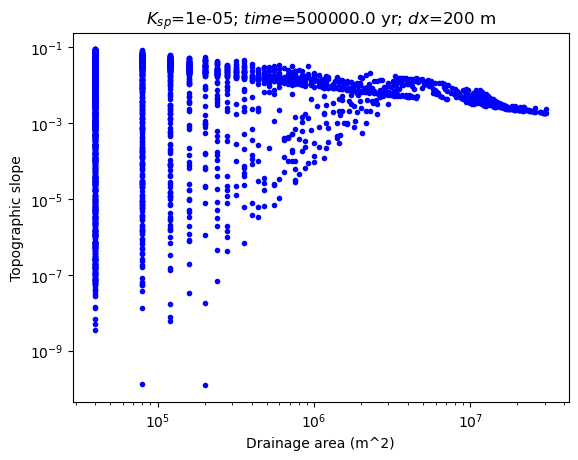

In [9]:
# Code Block 9

plt.loglog(
    mg1.at_node["drainage_area"][mg1.core_nodes],
    mg1.at_node["topographic__steepest_slope"][mg1.core_nodes],
    "b.",
)
plt.ylabel("Topographic slope")
plt.xlabel("Drainage area (m^2)")
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m"

plt.title(title_text)

É um pouco mais fácil interpretar os dados declividade‑área quando se observa um único canal em vez de toda a paisagem. Abaixo mostramos o perfil e os dados declividade‑área dos três maiores canais.

Text(0.5, 1.0, '$K_{sp}$=1e-05; $time$=500000.0 yr; $dx$=200 m')

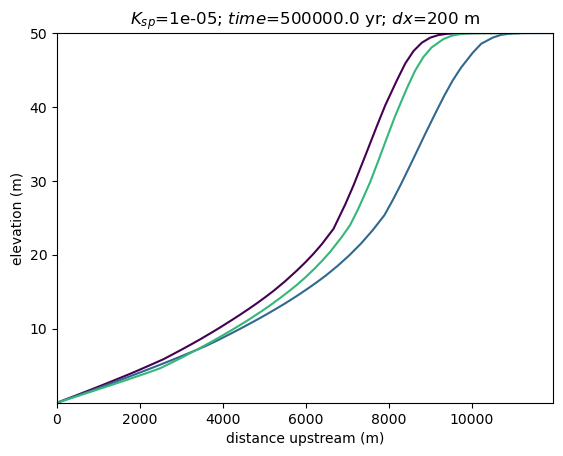

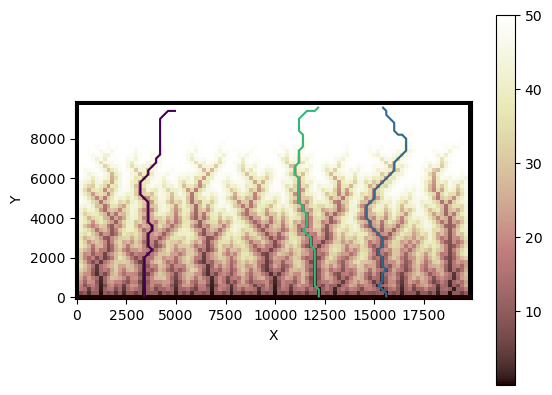

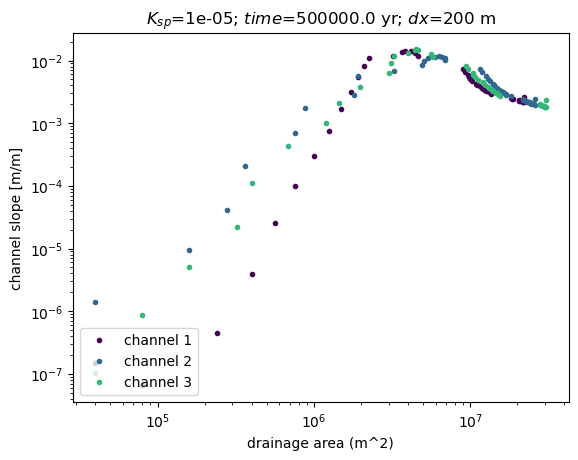

In [10]:
# Code Block 10

# profile the largest channels, set initially to find the mainstem channel in the three biggest watersheds
# you can change the number of watersheds, or choose to plot all the channel segments in the watershed that
# have drainage area below the threshold (here we have set the threshold to the area of a grid cell).
prf = ChannelProfiler(
    mg1,
    number_of_watersheds=3,
    main_channel_only=True,
    minimum_channel_threshold=dxy**2,
)
prf.run_one_step()

# plot the elevation as a function of distance upstream
plt.figure(1)
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m"
prf.plot_profiles(
    xlabel="distance upstream (m)", ylabel="elevation (m)", title=title_text
)

# plot the location of the channels in map view
plt.figure(2)
prf.plot_profiles_in_map_view()

# slope-area data in just the profiled channels
plt.figure(3)
for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = f"channel {i + 1}"
        else:
            label = "_nolegend_"
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg1.at_node["drainage_area"][profile_ids],
            mg1.at_node["topographic__steepest_slope"][profile_ids],
            ".",
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m"
plt.title(title_text)

O índice χ (chi) é uma forma útil de interpretar quantitativamente canais fluviais. Abaixo apresentamos o índice χ nos três maiores canais e também um mapa χ de toda a paisagem.

In [ ]:
# Code Block 11

# calculate the chi index
cf.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(4)

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = f"channel {i + 1}"
        else:
            label = "_nolegend_"
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg1.at_node["channel__chi_index"][profile_ids],
            mg1.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = (
    f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={theta}"
)
plt.title(title_text)

# chi map
plt.figure(5)
mg1.imshow(
    "channel__chi_index",
    grid_units=("m", "m"),
    var_name="Chi index (m)",
    cmap="jet",
)
title_text = (
    f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={theta}"
)
plt.title(title_text)

O índice de declividade do canal é outro parâmetro útil para quantificar canais fluviais. Abaixo apresentamos esse índice nos mesmos três maiores canais e também em toda a grade.

In [ ]:
# Code Block 12

# calculate channel steepness
sf.calculate_steepnesses()

# plots of steepnes vs. distance upstream in the profiled channels
plt.figure(6)

for i, outlet_id in enumerate(prf.data_structure):
    for j, segment_id in enumerate(prf.data_structure[outlet_id]):
        if j == 0:
            label = f"channel {i + 1}"
        else:
            label = "_nolegend_"
        segment = prf.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(
            distance_upstream,
            mg1.at_node["channel__steepness_index"][profile_ids],
            "x",
            color=color,
            label=label,
        )

plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
plt.title(f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={theta}")

# channel steepness map
plt.figure(7)
mg1.imshow(
    "channel__steepness_index",
    grid_units=("m", "m"),
    var_name="Steepness index ",
    cmap="jet",
)
title_text = (
    "$K_{sp}$="
    + str(K_sp)
    + "; $time$="
    + str(total_time)
    + "yr; $dx$="
    + str(dxy)
    + "m"
    + "; concavity="
    + str(theta)
)
plt.title(f"$K_{{sp}}$={K_sp}; $time$={total_time} yr; $dx$={dxy} m; concavity={theta}")

Se você quiser exportar uma grade, descomente e edite as linhas apropriadas abaixo e execute o bloco de código.

In [ ]:
# Code Block 13

## Below has the name of the file that data will be written to.
## You need to change the name of the file every time that you want
## to write data, otherwise you will get an error.
## This will write to the directory that you are running the code in.
# write_file_name = 'data_file.txt'
## Below is writing elevation data in the ESRI ascii format so that it can
## easily be read into Arc GIS or back into Landlab.
# with open(write_file_name, "w") as fp:
#     dump(fp, mg1, name="topographic__elevation", at="node")

Depois de executar cada bloco de código uma vez, a paisagem chegou ao estado estacionário? **NÃO!** Como você sabe? Após refletir sobre isso, você está pronto para concluir o projeto.

Responda às perguntas abaixo utilizando o código acima e abaixo. Todas as respostas devem ser digitadas, e as figuras de suporte (geradas pelos Blocos 8‑12 e 18‑21) devem ser incorporadas em um único documento a ser entregue. Você pode usar qualquer uma dessas figuras que julgar necessárias (faça download ou capture a tela).

Qualquer item terminado em “?” deve ser respondido no documento que você irá entregar. Escreva em frases completas e revise o texto antes de entregar.

1. **Estado estacionário com baixa taxa de soerguimento.** Usando os parâmetros fornecidos inicialmente, execute o modelo até atingir o estado estacionário. Observe aproximadamente quanto tempo foi necessário. Inclua gráficos apropriados. (Se quiser analisar essas paisagens fora do Landlab ou salvar para depois, certifique‑se de salvar os dados de elevação usando o Bloco 13.)

**ATENÇÃO – Para as demais questões utilize os Blocos 14 a 21.** Eles permitem usar a paisagem em estado estacionário produzida na questão 1 (paisagem “base”) como condição inicial. Comece editando o que for necessário nos Blocos 14‑16 e execute‑os uma vez, em sequência. Você pode executar o Bloco 17 (loop de tempo) quantas vezes precisar, assim como os Blocos 18‑21, que geram os gráficos.

2. **Paisagem transitória respondendo a aumento uniforme do soerguimento.** A partir da paisagem base, aumente uniformemente a taxa de soerguimento em 4× para 0,0004 m/ano. Atualize o Bloco 16 e ajuste $t_{max}$ para 1e5 anos e $dt$ para 500 anos (Bloco 15). Execute o modelo até que a elevação máxima atinja ~170 m, registrando etapas intermediárias. Quais padrões nos gráficos ilustram essa resposta transitória? Quais padrões, se houver, são diagnósticos de uma paisagem respondendo a um aumento uniforme de U? (Talvez só seja possível responder depois de concluir todas as questões.)

3. **Novo estado estacionário com U aumentado.** Continue executando o modelo até que a paisagem da questão 2 alcance um novo estado estacionário (você pode aumentar $t_{max}$ e $dt$ para acelerar a simulação). Apresente um gráfico que demonstre o equilíbrio e descreva o que mudou em relação à paisagem base.

4. **Aumentar erodibilidade.** Volte à paisagem base, porém aumente $K_{sp}$ para 2 × 10⁻⁵ (Bloco 14) mantendo U = 0,0001 m/ano (Bloco 16). Defina $t_{max}$ = 1e5 anos (Bloco 15). Execute por 1e5 anos e salve os gráficos que considerar diagnósticos; depois por mais 1e5 anos; depois por 5e5 anos. Descreva quantitativamente como a paisagem evolui e indique possíveis motivos para um aumento uniforme na erodibilidade.

5. **Soerguimento espacialmente variável — terremoto discreto.** Volte à paisagem base ($K_{sp}$ = 1 × 10⁻⁵). Adicione uma falha horizontal em y = 4000 m que eleva instantaneamente metade da paisagem em 10 m (Bloco 16). Mantenha o soerguimento de fundo em 0,0001 m/ano. Defina $t_{max}$ = 1e5 anos e $dt$ = 500 anos (Bloco 15). Execute o Bloco 17 quatro vezes, analisando os gráficos a cada loop. Como a paisagem responde à falha? Quais padrões nos gráficos são diagnósticos de uma resposta a um terremoto?

6. **Soerguimento espacialmente variável — falha discreta com duas taxas.** Volte à paisagem base ($K_{sp}$ = 1 × 10⁻⁵). Adicione uma falha em y = 4000 m com taxas de soerguimento de 0,0004 m/ano no footwall e 0,0001 m/ano no hanging‑wall (Bloco 16). Defina $t_{max}$ = 1e5 anos e $dt$ = 500 anos. Execute o loop quatro vezes e descreva os padrões observados.

7. **Soerguimento espacialmente variável — gradiente linear.** Volte à paisagem base ($K_{sp}$ = 1 × 10⁻⁵). Imponha um gradiente linear de U, variando de 0,0001 m/ano na frente da cordilheira até 0,0004 m/ano no núcleo (Bloco 16). Defina $t_{max}$ = 1e5 anos e $dt$ = 500 anos. Execute o loop quatro vezes e descreva a resposta da paisagem.

8. **Reflexão final.** Seu palpite inicial sobre como os parâmetros afetariam a paisagem estava correto? Discuta em até 6 frases.


In [ ]:
# Code Block 14

number_of_rows = 50  # number of raster cells in vertical direction (y)
number_of_columns = 100  # number of raster cells in horizontal direction (x)
dxy2 = 200  # side length of a raster model cell, or resolution [m]

# Below is a raster (square cells) grid, with equal width and height
mg2 = RasterModelGrid((number_of_rows, number_of_columns), dxy2)

# Set boundary conditions - only the south side of the grid is open.
# Boolean parameters are sent to function in order of
# east, north, west, south.
mg2.set_closed_boundaries_at_grid_edges(True, True, True, False)

z2 = z1.copy()  # initialize the elevations with the steady state
# topography produced for question 1
z2 = mg2.add_field("topographic__elevation", z2, at="node")

# K_sp value for base landscape is 1e-5
K_sp2 = 1e-5  # units vary depending on m_sp and n_sp
m_sp2 = 0.5  # exponent on drainage area in stream power equation
n_sp2 = 1.0  # exponent on slope in stream power equation

frr2 = FlowAccumulator(mg2, flow_director="FlowDirectorD8")  # intializing flow routing

# initializing stream power incision
spr2 = StreamPowerEroder(mg2, K_sp=K_sp2, m_sp=m_sp2, n_sp=n_sp2, threshold_sp=0.0)

theta2 = m_sp2 / n_sp2
# initialize the component that will calculate channel steepness
sf2 = SteepnessFinder(mg2, reference_concavity=theta2, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf2 = ChiFinder(
    mg2, min_drainage_area=1000.0, reference_concavity=theta2, use_true_dx=True
)

In [ ]:
# Code Block 15

tmax = 1e5  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 500  # time step [yr] (Original value was 500 yr)

In [ ]:
# Code Block 16

#  uplift_rate [m/yr] (value was 0.0001 m/yr for base landscape)
uplift_rate = np.ones(mg2.number_of_nodes) * 0.0001

## If you want to add a one-time event that uplifts only part of the
## landscape, uncomment the 3 lines below
# fault_location = 4000  # [m]
# uplift_amount = 10 # [m]
# z2[np.nonzero(mg2.node_y>fault_location)] += uplift_amount

## IMPORTANT! To use the below fault generator, comment the one-time
## uplift event above if it isn't already commented out.
## Code below creates a fault horizontally across the grid.
## Uplift rates are greater where y values  > fault location.
## To use, uncomment the 5 code lines below and edit to your values
# fault_location = 4000  # [m]
# low_uplift_rate = 0.0001 # [m/yr]
# high_uplift_rate = 0.0004 # [m/yr]
# uplift_rate[np.nonzero(mg2.node_y<fault_location)] = low_uplift_rate
# uplift_rate[np.nonzero(mg2.node_y>fault_location)] = high_uplift_rate

## IMPORTANT! To use below rock uplift gradient, comment the two
## uplift options above if they aren't already commented out.
## If you want a linear gradient in uplift rate
## (increasing uplift into the range),
## uncomment the 4 code lines below and edit to your values.
# low_uplift_rate = 0.0001 # [m/yr]
# high_uplift_rate = 0.0004 # [m/yr]
## below is uplift gradient per node row index, NOT row value in meters
# uplift_rate_gradient = (high_uplift_rate - low_uplift_rate)/(number_of_rows-3)
# uplift_rate = low_uplift_rate + ((mg2.node_y / dxy)-1) * uplift_rate_gradient

In [ ]:
# Code Block 17

total_time = 0.0
with tqdm(total=tmax) as pbar:
    while total_time < tmax:
        z2[mg2.core_nodes] += uplift_rate[mg2.core_nodes] * dt  # uplift the landscape
        frr2.run_one_step()  # route flow
        spr2.run_one_step(dt)  # fluvial incision
        total_time += dt  # update time keeper

        pbar.update(dt)

In [ ]:
# Code Block 18
# Plot topography

plt.figure(8)
mg2.imshow("topographic__elevation", grid_units=("m", "m"), var_name="Elevation (m)")
plt.title(f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m")

max_elev = np.max(z2)
print(f"Maximum elevation is {np.max(z2)}")

In [ ]:
# Code Block 19
# Plot Channel Profiles and slope-area data along the channels

prf2 = ChannelProfiler(
    mg2,
    number_of_watersheds=3,
    main_channel_only=True,
    minimum_channel_threshold=dxy**2,
)
prf2.run_one_step()

# plot the elevation as a function of distance upstream
plt.figure(9)
title_text = f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy} m"
prf2.plot_profiles(
    xlabel="distance upstream (m)", ylabel="elevation (m)", title=title_text
)

# plot the location of the channels in map view
plt.figure(10)
prf2.plot_profiles_in_map_view()

# slope-area data in just the profiled channels
plt.figure(11)
for i, outlet_id in enumerate(prf2.data_structure):
    for j, segment_id in enumerate(prf2.data_structure[outlet_id]):
        if j == 0:
            label = f"channel {i + 1}"
        else:
            label = "_nolegend_"
        segment = prf2.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.loglog(
            mg2.at_node["drainage_area"][profile_ids],
            mg2.at_node["topographic__steepest_slope"][profile_ids],
            ".",
            color=color,
            label=label,
        )

plt.legend(loc="lower left")
plt.xlabel("drainage area (m^2)")
plt.ylabel("channel slope [m/m]")
title_text = f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m"
plt.title(title_text)

In [ ]:
# Code Block 20
# Chi Plots

# calculate the chi index
cf2.calculate_chi()

# chi-elevation plots in the profiled channels
plt.figure(12)
for i, outlet_id in enumerate(prf2.data_structure):
    for j, segment_id in enumerate(prf2.data_structure[outlet_id]):
        if j == 0:
            label = f"channel {i + 1}"
        else:
            label = "_nolegend_"
        segment = prf2.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        color = segment["color"]
        plt.plot(
            mg2.at_node["channel__chi_index"][profile_ids],
            mg2.at_node["topographic__elevation"][profile_ids],
            color=color,
            label=label,
        )

plt.xlabel("chi index (m)")
plt.ylabel("elevation (m)")
plt.legend(loc="lower right")
title_text = (
    f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m; concavity={theta2}"
)
plt.title(title_text)

# chi map
plt.figure(13)
mg2.imshow(
    "channel__chi_index",
    grid_units=("m", "m"),
    var_name="Chi index (m)",
    cmap="jet",
)
plt.title(
    f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m; concavity={theta2}"
)

In [ ]:
# Code Block 21
# Plot channel steepness along profiles and across the landscape

# calculate channel steepness
sf2.calculate_steepnesses()

# plots of steepnes vs. distance upstream in the profiled channels
plt.figure(14)

for i, outlet_id in enumerate(prf2.data_structure):
    for j, segment_id in enumerate(prf2.data_structure[outlet_id]):
        if j == 0:
            label = f"channel {i + 1}"
        else:
            label = "_nolegend_"
        segment = prf2.data_structure[outlet_id][segment_id]
        profile_ids = segment["ids"]
        distance_upstream = segment["distances"]
        color = segment["color"]
        plt.plot(
            distance_upstream,
            mg2.at_node["channel__steepness_index"][profile_ids],
            "x",
            color=color,
            label=label,
        )

plt.xlabel("distance upstream (m)")
plt.ylabel("steepness index")
plt.legend(loc="upper left")
plt.title(
    f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m; concavity={theta2}"
)

# channel steepness map
plt.figure(15)
mg2.imshow(
    "channel__steepness_index",
    grid_units=("m", "m"),
    var_name="Steepness index ",
    cmap="jet",
)
plt.title(
    f"$K_{{sp}}$={K_sp2}; $time$={total_time} yr; $dx$={dxy2} m; concavity={theta2}"
)